In [4]:
import numpy as np
import pandas as pd

In [5]:
weather = pd.read_csv('Datasets/weather.csv', index_col = 'Date')
price = pd.read_csv('Datasets/Data.csv', index_col='Date', parse_dates=True)

In [6]:
price = price[(price.index > '2010-01-01') & (price.index < '2019-01-01')]
price = price[::-1]
price.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-01-04,418.50,415.75,426.25,413.25,140.55K,1.03%
2010-01-05,418.75,417.25,420.00,415.25,80.97K,0.06%
2010-01-06,421.75,418.00,422.00,416.00,96.45K,0.72%
2010-01-07,417.50,421.00,424.00,414.50,137.40K,-1.01%
2010-01-08,423.00,417.50,423.75,415.00,135.00K,1.32%


In [7]:
weather.head()

,TMAX,TMIN,PRCP,SNOW
Date,,,,
2010-01-01,-31.046402,-74.829545,3.594223,4.698390
2010-01-02,-52.175943,-101.472170,3.552830,7.444340
2010-01-03,-57.468414,-103.546093,2.228358,5.344408
2010-01-04,-46.521938,-88.392139,2.521024,5.994973
2010-01-05,-40.622883,-76.595881,2.895195,4.625172


In [32]:
#Merge the two dataframes based on Index
final = pd.concat([price, weather],axis=1)
#final = final.fillna(0)
final.dropna(inplace=True)
final['Vol.'] = final['Vol.'].str.slice(0,-1)
index = final.index.values
final.head()

,Price,Open,High,Low,Vol.,Change %,TMAX,TMIN,PRCP,SNOW
Date,,,,,,,,,,
2010-01-04,418.50,415.75,426.25,413.25,140.55,1.03%,-46.521938,-88.392139,2.521024,5.994973
2010-01-05,418.75,417.25,420.00,415.25,80.97,0.06%,-40.622883,-76.595881,2.895195,4.625172
2010-01-06,421.75,418.00,422.00,416.00,96.45,0.72%,-34.017431,-72.576606,3.870642,3.200000
2010-01-07,417.50,421.00,424.00,414.50,137.40,-1.01%,-30.523176,-61.433685,31.739330,45.121615
2010-01-08,423.00,417.50,423.75,415.00,135.00,1.32%,-35.299818,-68.329845,32.447680,47.646497


In [34]:
final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2429 entries, 2010-01-04 to 2018-12-31
Data columns (total 10 columns):
Price       2429 non-null float64
Open        2429 non-null float64
High        2429 non-null float64
Low         2429 non-null float64
Vol.        2429 non-null object
Change %    2429 non-null object
TMAX        2429 non-null float64
TMIN        2429 non-null float64
PRCP        2429 non-null float64
SNOW        2429 non-null float64
dtypes: float64(8), object(2)
memory usage: 208.7+ KB


In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
labels = final.drop(['Price','Change %','High','Low','Open','Vol.'], axis=1)

In [37]:
labels = pd.DataFrame(scaler.fit_transform(labels))
labels.columns = ['PRCP','TMAX', 'TMIN', 'SNOW']
labels = labels.set_index(index)

In [38]:
labels.head()

,PRCP,TMAX,TMIN,SNOW
2010-01-04,0.150927,0.125927,0.007841,0.050645
2010-01-05,0.179005,0.185362,0.009005,0.039073
2010-01-06,0.210446,0.205613,0.012040,0.027033
2010-01-07,0.227078,0.261756,0.098758,0.381185
2010-01-08,0.204342,0.227010,0.100962,0.402515


In [39]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2429 entries, 2010-01-04 to 2018-12-31
Data columns (total 4 columns):
PRCP    2429 non-null float64
TMAX    2429 non-null float64
TMIN    2429 non-null float64
SNOW    2429 non-null float64
dtypes: float64(4)
memory usage: 94.9 KB


In [40]:
#Train Test Split X
X_test= labels.tail(429)
X_train = labels.head(2000)

In [41]:
final[final['Price']==0]

,Price,Open,High,Low,Vol.,Change %,TMAX,TMIN,PRCP,SNOW
Date,,,,,,,,,,


In [42]:
prices = pd.DataFrame(scaler.fit_transform(pd.DataFrame(final['Price'])))
prices.columns = ['Price']
prices = prices.set_index(index)
prices=prices['Price'].map(lambda x: prices.Price.mean() if x == 0 else x)

In [43]:
# Test Train split Y
y_test= prices.tail(429)
y_train = prices.head(2000)

In [44]:
y_train[y_train==0]

Series([], Name: Price, dtype: float64)

In [45]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [47]:
model = Sequential()
model.add(Dense(18,activation='relu',input_shape=(4, )))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='mse',metrics=['mape'])
model.fit(X_train, y_train,epochs=50,batch_size=20, verbose=1)
predictions = model.predict(X_test)

W0816 20:45:12.909955 4668515776 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0816 20:45:12.979565 4668515776 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/50
2000/2000 [==============================] - 1s 408us/step - loss: 0.0824 - mean_absolute_percentage_error: 141.7810
Epoch 2/50
2000/2000 [==============================] - 0s 56us/step - loss: 0.0821 - mean_absolute_percentage_error: 143.6212
Epoch 3/50
2000/2000 [==============================] - 0s 56us/step - loss: 0.0821 - mean_absolute_percentage_error: 142.4673
Epoch 4/50
2000/2000 [==============================] - 0s 56us/step - loss: 0.0822 - mean_absolute_percentage_error: 143.8884
Epoch 5/50
2000/2000 [==============================] - 0s 57us/step - loss: 0.0823 - mean_absolute_percentage_error: 142.7935
Epoch 6/50
2000/2000 [==============================] - 0s 56us/step - loss: 0.0820 - mean_absolute_percentage_error: 142.7295
Epoch 7/50
2000/2000 [==============================] - 0s 55us/step - loss: 0.0819 - mean_absolute_percentage_error: 141.9911
Epoch 8/50
2000/2000 [==============================] - 0s 57us/step - loss: 0.0819 - mean_absolute_percentage

In [48]:
results = np.array(predictions).reshape(429
                                        ,1)

In [49]:
results = scaler.inverse_transform(results)
y_test_scaled = scaler.inverse_transform(np.array(y_test).reshape(429,1))
results[0]

array([477.27457], dtype=float32)

In [50]:
y_test_scaled[0]

array([371.5])

In [51]:
pred = pd.DataFrame(results)

In [52]:
true = pd.DataFrame(y_test_scaled)

In [53]:
date_rng = pd.date_range(start='28-10-2017', end='31-12-2018', freq='D')
dq = pd.DataFrame(date_rng, columns=['date'])

In [54]:
pred['Date'] = dq
pred.columns = ['Predictions', 'Date']
true['Date'] = dq
true.columns = ['Actual', 'Date']
final_results = pd.merge(pred, true, on='Date')
final_results.set_index(final_results.Date, inplace = True)
final_results.drop('Date', axis=1, inplace=True)
final_results['Difference %'] = ((final_results.Actual- final_results.Predictions)/final_results.Actual)
final_results['Difference'] = (final_results.Actual- final_results.Predictions)
final_results.head()

,Predictions,Actual,Difference %,Difference
Date,,,,
2017-10-28,477.274567,371.5,-0.284723,-105.774567
2017-10-29,478.300507,366.0,-0.306832,-112.300507
2017-10-30,492.068634,372.5,-0.320990,-119.568634
2017-10-31,446.340851,375.0,-0.190242,-71.340851
2017-11-01,454.318634,369.5,-0.229550,-84.818634


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

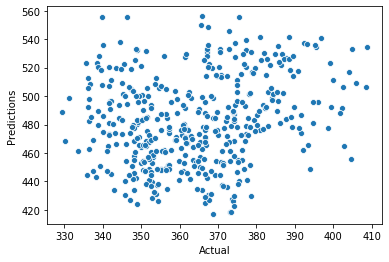

In [56]:
sns.scatterplot('Actual', 'Predictions', data=final_results)

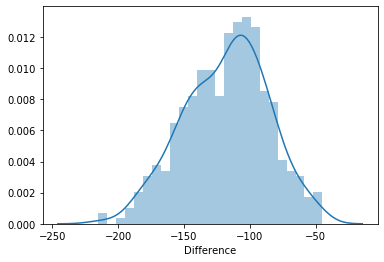

In [57]:
sns.distplot(final_results.Difference, bins=25)

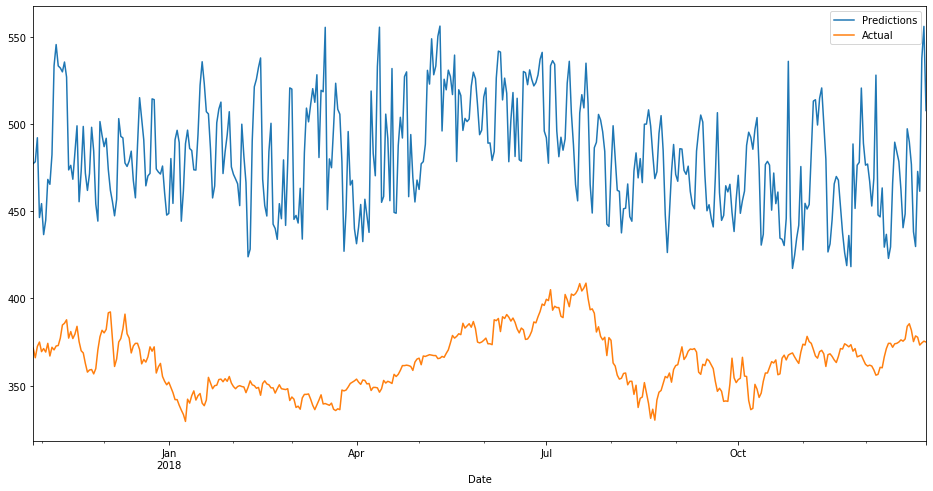

In [58]:
final_results.Predictions.plot( figsize=(16,8))
final_results.Actual.plot()
plt.legend()